### Creating a new pandas with the new corrected coordinates

**Importing libraries**

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

**Funksjoner**

In [2]:
def read_tif_npy(band_name):
    npy = "../data_for_malan/HyperSpectral4_" + band_name + ".npy"
    tif = "../data_for_malan/HyperSpectral4_" + band_name + ".tif"
    coord = np.load(npy)
    coord = coord.reshape(1000000, 2)
    data = None
    with rio.open(tif, 'r') as f:
        data = f.read(1).reshape(1000000)
    return data, coord


#brukes til å definere hvilke lat og lon som er i samme 30x30 coordinat grid
def cartesian(lat, lon): 
    R = 6378137.0 
    X = R * np.cos(lon) * np.sin(lat)
    Y = R * np.sin(lon) * np.sin(lat)
    return X , Y


def labelling(dataframes, lat_min, lat_max, lon_min, lon_max):
    '''
    Input: 

    Output: 

    '''
    global df_prisma
    if len(dataframes):
        dlat = lat_max-lat_min
        dlon = lon_max-lon_min

        if dlat >dlat_min and dlon >dlon_min:
            dataframes_upper_left = []
            dataframes_upper_right = []
            dataframes_lower_left = []
            dataframes_lower_right = []

            lat_middle = lat_min + dlat/2
            lon_middle = lon_min + dlon/2


            for dataframe in dataframes: 
                if not dataframe.empty: 

                    dataframes_upper_left.append(dataframe.loc[(dataframe["lat"]>lat_middle) &(dataframe["lon"]<lon_middle)])
                    dataframes_upper_right.append(dataframe.loc[(dataframe["lat"]>lat_middle) &(dataframe["lon"]>lon_middle)])
                    dataframes_lower_right.append(dataframe.loc[(dataframe["lat"]<=lat_middle) &(dataframe["lon"]>=lon_middle)])
                    dataframes_lower_left.append(dataframe.loc[(dataframe["lat"]<=lat_middle) &(dataframe["lon"]<=lon_middle)])
            
            labelling(dataframes_upper_left, lat_middle, lat_max, lon_min, lon_middle)
            labelling(dataframes_upper_right, lat_middle, lat_max, lon_middle, lon_max)
            labelling(dataframes_lower_right, lat_min, lat_middle, lon_middle, lon_max)
            labelling(dataframes_lower_left, lat_min, lat_middle, lon_min, lon_middle)
        else: 
            #print(f"Now we have arrived at the bottom, and lat is {lat_min} and lon is {lon_min}")
            lat = lat_min + dlat/2
            lon = lon_min + dlon/2
            row = {"lat": [lat], "lon": [lon]}
            for dataframe in dataframes:
                if not dataframe.empty: 
                    new = dataframe.drop(columns = ["lat", "lon"])
                    row[new.columns[0]] =[ new[new.columns[0]].mean()]
            row = pd.DataFrame.from_dict(row, orient = "columns")
            df_prisma = pd.concat([df_prisma, row], ignore_index=True)
        

**Finner min og max lat og lon av prisma dataen**



In [3]:
#Runtime 10 s


lat_min = 1000
lat_max = 0
lon_min = 1000 
lon_max = 0 

dataframes = []
for i in range(66):
    try: 
        filename = "band_" + str(400 + i*10)
        band, coord = read_tif_npy(filename)


        data = pd.DataFrame()
        data[filename] = band
        data["lat"] = coord[:,0]
        data["lon"] = coord[:,1]

        dataframes.append(data)
        lat_min_current = min(coord[:,0])
        lat_max_current = max(coord[:,0])

        lon_min_current = min(coord[:,1])
        lon_max_current = max(coord[:,1])

        lat_min = min(lat_min, lat_min_current)
        lon_min = min(lon_min, lon_min_current)
        lat_max = max(lat_max, lat_max_current)
        lon_max = max(lon_max, lon_max_current)
        

    except: 
        None


**FInner dlat og dlon for 30 meter**


In [4]:
#finding dlat and dlon numerically
dlat_list = np.linspace(0.00001,0, 100)
dlon_list = np.linspace(0.00001,0, 100)

x_min, y_min = cartesian(lat_min, lon_min)

dx = 100
dy = 100
for dlat, dlon in zip(dlat_list, dlon_list):
    x_new, y_new = cartesian(lat_min + dlat, lon_min + dlon)
    dx = abs(x_new - x_min)
    dy = abs(y_new - y_min)
    if  dx <30 and dy <30: 
        print(dlat)
        print(dlon)
        break

4.747474747474748e-06
4.747474747474748e-06


**Finner valid filnavn**



In [5]:
#Runtime 2 s
list_valid_filenames = []
for i in range(66):
    try: 
        filename = "band_" + str(400 + i*10)
        band, coord = read_tif_npy(filename)
        list_valid_filenames.append(filename)
    except: 
        None

**Creating new dataframe**

In [6]:
global dlat_min
global dlon_min

dlat_min = 0.03
dlon_min = 0.03

global df_prisma
df_prisma = pd.DataFrame(columns=list_valid_filenames)

labelling(dataframes, lat_min, lat_max, lon_min, lon_max)


**Adding rows for lat and lons which are going to be interpolated**

In [7]:
df_new = pd.DataFrame(columns = ["lat", "lon"])

lon,lat = np.meshgrid( np.arange(lon_min,lon_max,dlon_min), np.arange(lat_min,lat_max,dlat_min))
lon = lon.flatten()
lat = lat.flatten()


df_new["lat"] = lat 
df_new["lon"] = lon 

In [8]:
df_new.columns

Index(['lat', 'lon'], dtype='object')

**Interpolating the bandwidth**




In [9]:
df_all = df_prisma.copy()
df_all = df_all.merge(df_new, how = "outer", on = ["lat", "lon"])

grid_x, grid_y = np.mgrid[lat_min:lat_max:dlat_min,lon_min:lon_max:dlon_min]

from scipy.interpolate import griddata
def interpolating(band, dataframe):
    data = dataframe[[band, "lat", "lon"]].copy()
    data = dataframe.dropna()
    points = np.array([data.lat, data.lon]).T
    grid = griddata(points, data[band], (lat, lon), method='nearest')
    dataframe[band] = grid.flatten()


interpolating('band_430', df_all)


ValueError: Length of values (300) does not match length of index (508)

**Exporting data**

In [132]:
df_prisma.to_pickle("..\data\df_prisma.pkl")

**Plot of the new data**

<AxesSubplot:>

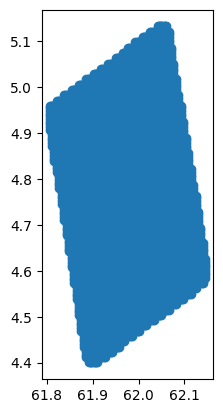

In [133]:
geo_prisma = gpd.GeoDataFrame(df_prisma, geometry = gpd.points_from_xy(df_prisma.lat, df_prisma.lon))
geo_prisma.plot()

**Plot of Runtime**

In [138]:
d_list = [0.03,0.02,0.01,0.009, 0.008, 0.004]
dtime = [19, 41,  2*60 + 8, 2*60 + 9, 2* 60 + 12,9 * 60 +54 ]

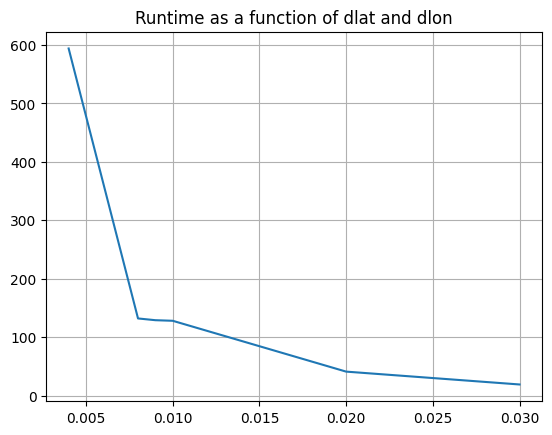

In [139]:
import matplotlib.pyplot as plt 
plt.title("Runtime as a function of dlat and dlon")
plt.plot(d_list, dtime)
plt.grid()

**Kommentar**
Eksponensiell vekst i kjøretid
